# Validation of dynamic solver

The solution methods are implemented in lin_uvlm2d_dyn.solver, while tests are recorded in test_lindyn.py. Unless otherwise specified, a flat plate is always considered in these tests. The linearisation is about the 0 deg angle of attack position.

#### Important:
   This version of the linear solver is based on a linearisation of both state and output equations. 
   Being $\Gamma_0$ the circulation at the reference (linearisation) point, and $\Delta\Gamma$ the incremental circulation, the total circulation is computed as:
$$\Gamma=\Gamma_0+\Delta\Gamma$$
Similarly, the total aerodynamic force is obtained as:
$$
F = F_0 + \Delta F
$$

In summary, the discrete-time state-space formulation used is:
$$
\Delta x^{n+1}=A \Delta x^n + B \Delta u^{n+1} \\
\Delta y^{n+1} = C \Delta x^{n+1} + D \Delta u^{n+1}
$$
where $x$ and $u$ are system state and input.

In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import copy
import sys
sys.path.append('../')

import uvlm2d_sta
import uvlm2d_dyn
import lin_uvlm2d_dyn
import pp_uvlm2d as pp
import analytical as an
import geo, set_dyn, set_gust

from IPython.utils import io

## Steady state:
This case looks at the solution at a steady angle of attack. The wake is used in the time-stepping procedure, but should have no impact on the solution accuracy. A very short wake is, therefore, used. Hall's correction (1994) should also have no impact on the results.

The total angle of attack is given by 
$$
\alpha=\alpha_0 + \Delta\alpha
$$
where $\Delta\alpha$ is produced enforcing a set of incremental $x,z$ nodal displacements. As a result, the total aerodynamic force is given by $F=F_0+\Delta F$

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


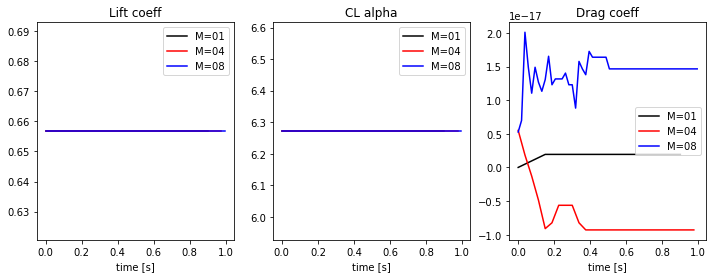

In [2]:
### random geometry
c=3.
b=0.5*c
uinf=20.0
T=1.0
WakeFact=2
alpha0=4.00 * np.pi/180.
dalpha=2.00 * np.pi/180.
alpha_tot=alpha0+dalpha
TimeList=[]
THCFList=[]
MList=[1,4,8]
for mm in range(len(MList)):
    M=MList[mm]

    ### reference solution (static)
    S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
         Uinf=np.array([uinf,0.]),alpha=alpha0,rho=1.225)
    S0.build_flat_plate()
    S0.eps_Hall=1.0 # no correction
    S0.solve_static_Gamma2d()
    Ftot0=np.sum(S0.Faero,0)
    ### linearisation
    Slin=lin_uvlm2d_dyn.solver(S0,T)
    with io.capture_output() as captured:
        Slin.solve_dyn_Gamma2d()
    # perturb reference state
    ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
    dZeta=ZetaRot-S0.Zeta
    Slin.Zeta=dZeta
    for tt in range(Slin.NT):
        Slin.THZeta[tt,:,:]=dZeta
    # solve
    with io.capture_output() as captured:
        Slin.solve_dyn_Gamma2d()
    # total force
    THFtot=0.0*Slin.THFaero
    for tt in range(Slin.NT):
        THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0

    TimeList.append(Slin.time)
    THCFList.append(THFtot/S0.qinf/S0.chord)

clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Lift coeff')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1]/alpha_tot,clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CL alpha')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,0],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Drag coeff')
ax.legend()	
plt.show()

As expected:
- Hall's correction is not required. The correction, in fact, accumulates "net" vorticity at the last vortex. The nex vorticity in the wake is, however, null (despite the vortex rings carrying a non-zero vorticity, which is the accumulated vorticity at the aerofoil).
- Quantities remain constant, and the $CL_\alpha$ is always equal to $2\pi$. No induced drag, as expected.
- No jump in the aerodynamic force at the beginning of the simulation is observed. This holds whether $\alpha_0$ is zero or not.

Nothing changes when Hall's correction is introduced:

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


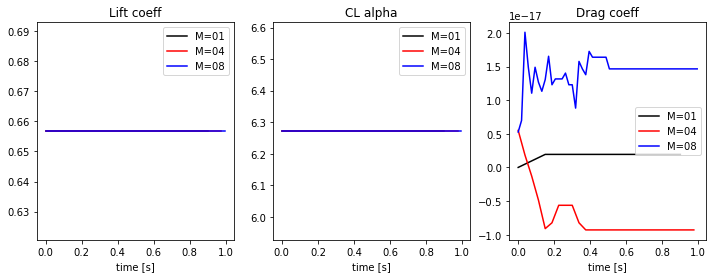

In [3]:
TimeList=[]
THCFList=[]
MList=[1,4,8]
for mm in range(len(MList)):
    M=MList[mm]

    ### reference solution (static)
    S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
         Uinf=np.array([uinf,0.]),alpha=alpha0,rho=1.225)
    S0.build_flat_plate()
    S0.eps_Hall=0.003
    S0.solve_static_Gamma2d()
    Ftot0=np.sum(S0.Faero,0)
    ### linearisation
    Slin=lin_uvlm2d_dyn.solver(S0,T)
    with io.capture_output() as captured:
        Slin.solve_dyn_Gamma2d()
    
    # perturb reference state
    ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
    dZeta=ZetaRot-S0.Zeta
    Slin.Zeta=dZeta
    for tt in range(Slin.NT):
        Slin.THZeta[tt,:,:]=dZeta
    # solve
    with io.capture_output() as captured:
        Slin.solve_dyn_Gamma2d()
    # total force
    THFtot=0.0*Slin.THFaero
    for tt in range(Slin.NT):
        THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0
    TimeList.append(Slin.time)
    THCFList.append(THFtot/S0.qinf/S0.chord)

clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Lift coeff')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1]/alpha_tot,clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CL alpha')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,0],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Drag coeff')
ax.legend()	
plt.show()

There is no need of a comparison with the previous results as the y scale of these plots is relatively small. The match is perfect.

### Steady aerofoil - incremental speed
In this test case, the effective angle of attack is:
$$
\alpha=\alpha_0 + \Delta\alpha + \alpha_\infty
$$
where $\alpha_\infty$ is obtained superimposing a perturbation to the incoming velocity flow.

For validation, the aerodynamic force is projected in wind axes and decomposed in terms of lift and drag.

Testing steady aerofoil M=4...
Testing steady aerofoil M=8...
Testing steady aerofoil M=16...


../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


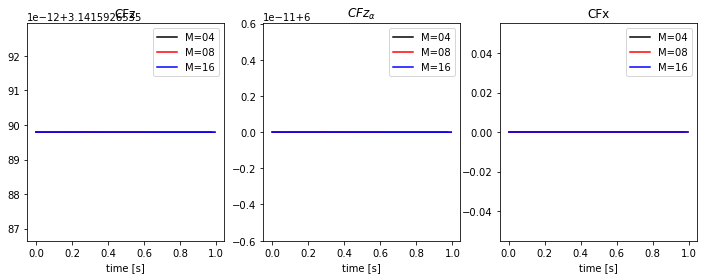

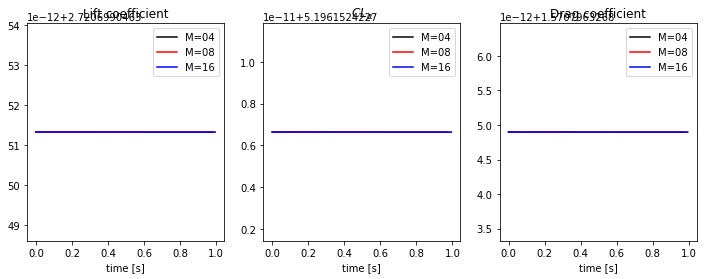

In [4]:
### random geometry
c=3.
b=0.5*c
Uinf0=np.array([20.0,0.0])
T=1.0
WakeFact=2
alpha0=0.00 * np.pi/180.
dalpha=0.00 * np.pi/180.
dalpha_inf=30.*np.pi/180.
alpha_tot=alpha0+dalpha+dalpha_inf
TimeList=[]
THCFList=[]

MList=[4,8,16]
for mm in range(len(MList)):

    M=MList[mm]
    print('Testing steady aerofoil M=%d...' %M)
    ### reference solution (static)
    S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                                      Uinf=Uinf0,alpha=alpha0,rho=1.225)
    S0.build_flat_plate()
    S0.eps_Hall=1.0 # no correction
    S0.solve_static_Gamma2d()
    Ftot0=np.sum(S0.Faero,0)
    ### linearisation
    Slin=lin_uvlm2d_dyn.solver(S0,T)
    # perturb reference state
    ZetaRot=geo.rotate_aerofoil(S0.Zeta,dalpha)
    dZeta=ZetaRot-S0.Zeta
    Slin.Zeta=dZeta
    Uinf=S0.Uabs*np.array([np.cos(dalpha_inf),np.sin(dalpha_inf)])
    #Slin.Wzeta[:,:]=(Uinf-Uinf0)
    Slin.dZetadt[:,:]=-(Uinf-Uinf0)
    for tt in range(Slin.NT):
        Slin.THZeta[tt,:,:]=dZeta
        #Slin.THWzeta[tt,:,:]=(Uinf-Uinf0)
        Slin.THdZetadt[tt,:,:]=-(Uinf-Uinf0)
    # solve
    with io.capture_output() as captured:
        Slin.solve_dyn_Gamma2d()
    # total force
    THFtot=0.0*Slin.THFaero
    for tt in range(Slin.NT):
        THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0
    TimeList.append(Slin.time)
    THCFList.append(THFtot/S0.qinf/S0.chord)

# post-process: rotate force in wind axes
THCFListRot=[]
cainf,sainf=np.cos(dalpha_inf),np.sin(dalpha_inf)
Rmat=np.array([[cainf,sainf],[-sainf,cainf]])
for mm in range(len(MList)):
    THCFRot=1.0*THCFList[mm]
    for tt in range(THCFRot.shape[0]):
        THCFRot[tt,:]=np.dot(Rmat,THCFRot[tt,:])
    THCFListRot.append(THCFRot)

clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1],clist[mm],
                                              label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CFz')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1]/alpha_tot,clist[mm],
                                              label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title(r'$CFz_\alpha$')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,0],clist[mm],
                                              label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CFx')
ax.legend()
plt.show()

clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces projected in wind axes',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFListRot[mm][:,1],clist[mm],
                                              label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFListRot[mm][:,1]/alpha_tot,clist[mm],
                                              label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title(r'$CL_\alpha$')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFListRot[mm][:,0],clist[mm],
                                              label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Drag coefficient')
ax.legend()
plt.show()


The aerodynamic force predicted is always perpendicular to the initial flow speed (which is aligned to the horizontal line). As a result, as the flow is perturbed and the aerodynamic force projected in wind axes, a drag force is computed --- and the lift is reduced. This behaviour is seen also in the static solution and is, overall, expected.





### Steady flat plate with incremental speed - verifying consistency with static solution

In this test, the UVLM model of a flat plate is linearised. In a first study, the flow speed is horizontal at the linearisation point. In a second one, the flow has a nonzero effective angle of attack.

The incoming flow is perturbed adding a steady incremental speed and a short time simulation is performed. Previous tests (see above) have already shown that the aerodynamic force predicted is constant. Here, the forces at the end of the simulation are recorded and plotted against the effective angle of attack to verify the force magnitude is correct.

##### Important:
In the code below, it is possible to select whether the incremental force is provided through gust or aerofoil motion. Results are unchanged.

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


	Alpha effective=0.00 deg
	Alpha effective=0.10 deg
	Alpha effective=0.20 deg
	Alpha effective=0.30 deg
	Alpha effective=0.50 deg
	Alpha effective=1.00 deg
	Alpha effective=2.00 deg
	Alpha effective=4.00 deg
	Alpha effective=6.00 deg
	Alpha effective=8.00 deg
	Alpha effective=9.50 deg
	Alpha effective=9.70 deg
	Alpha effective=9.80 deg
	Alpha effective=9.90 deg
	Alpha effective=10.00 deg
	Alpha effective=10.10 deg
	Alpha effective=10.20 deg
	Alpha effective=10.30 deg
	Alpha effective=10.50 deg
	Alpha effective=12.00 deg
	Alpha effective=14.00 deg
	Alpha effective=16.00 deg
	Alpha effective=18.00 deg


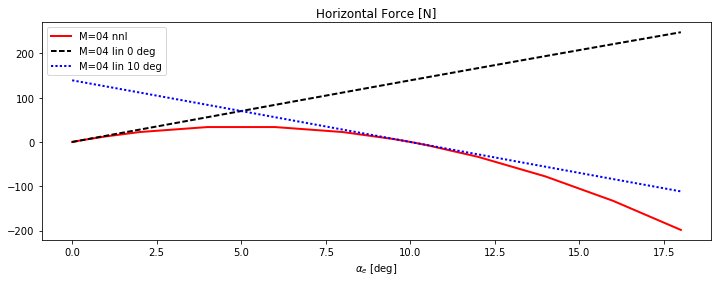

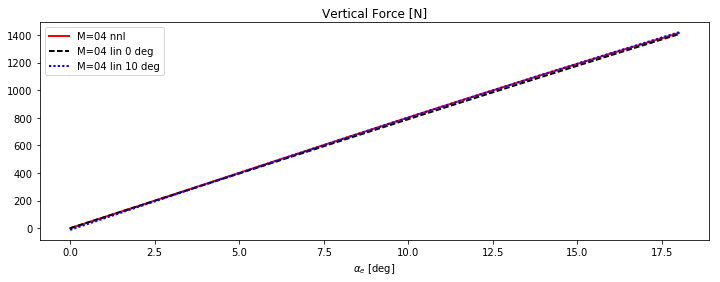

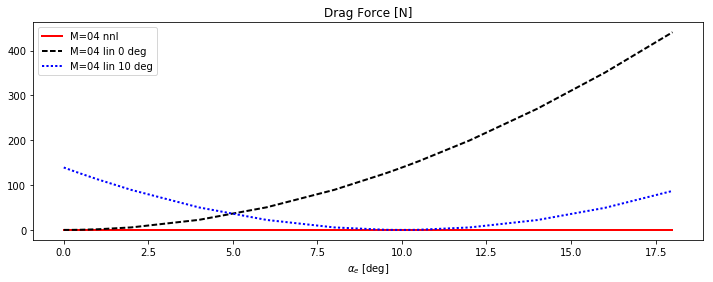

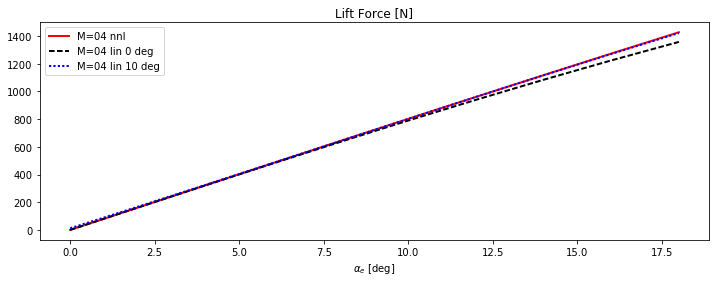

In [5]:
# select external velocity source
Gust=False#True
Aerofoil=True#False
if (Gust and Aerofoil) or (not Gust and not Aerofoil):
    raise NameError('Only one variable can be true!')

DAlphaList=[0.0,0.1,0.2,0.3,0.5,
            1.,2.,4.,6.,8.,
            9.5,9.7,9.8,9.9,10.,10.1,10.2,10.3,10.5,
            12.,14.,16.,18.] # degs
Na=len(DAlphaList)

CFXlin01,CFZlin01=np.zeros((Na,)),np.zeros((Na,))
CFXlin02,CFZlin02=np.zeros((Na,)),np.zeros((Na,))
CFXnnl,CFZnnl=np.zeros((Na,)),np.zeros((Na,))

FZlin01,FXlin01=np.zeros((Na,)),np.zeros((Na,))
FZlin02,FXlin02=np.zeros((Na,)),np.zeros((Na,))
FZnnl,FXnnl=np.zeros((Na,)),np.zeros((Na,))

Llin01,Dlin01=np.zeros((Na,)),np.zeros((Na,))
Llin02,Dlin02=np.zeros((Na,)),np.zeros((Na,))
Lnnl,Dnnl=np.zeros((Na,)),np.zeros((Na,))

### random geometry
M=4
c=3.
b=0.5*c
Uinf0=np.array([20.0,0.0])
rho=1.225
alpha0=10.00*np.pi/180.
dalpha=0.0
dt=c/M/np.linalg.norm(Uinf0)
T=6*dt
WakeFact=6
Mw=WakeFact*M

### reference condition 1/2: aerofoil at 0 deg angle
S01=uvlm2d_sta.solver(M,Mw,b,Uinf0,alpha0,rho)
S01.build_camber_plate(Mcamb=0,Pcamb=4)
S02=copy.deepcopy(S01)

alpha_eff01=0.*np.pi/180.
alpha_inf=alpha_eff01-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
if Gust: S01.Wzeta[:,:]=Uinf_here-Uinf0
if Aerofoil: S01.dZetadt[:,:]=-(Uinf_here-Uinf0)
S01.solve_static_Gamma2d()
Fref01=np.sum(S01.Faero,0)

alpha_eff02=10.*np.pi/180.
alpha_inf=alpha_eff02-alpha0
Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
if Gust: S02.Wzeta[:,:]=Uinf_here-Uinf0
if Aerofoil: S02.dZetadt[:,:]=-(Uinf_here-Uinf0)
S02.solve_static_Gamma2d()
Fref02=np.sum(S02.Faero,0)


for aa in range(len(DAlphaList)):
    
    # Perturbation
    alpha_eff=np.pi/180.*DAlphaList[aa]
    alpha_inf=alpha_eff-alpha0
    Uinf_here=geo.rotate_speed(Uinf0,alpha_inf)
    qinf_tot=0.5*rho*(S01.Uabs)**2
    print('\tAlpha effective=%.2f deg' %DAlphaList[aa])
                                     
    # Rotation matrix to project in wind axes
    ca,sa=np.cos(alpha_inf),np.sin(alpha_inf)
    R=np.array([[ca,-sa],[sa,ca]]).T  
    
    ### Reference nonlinear static solution
    Sref=uvlm2d_sta.solver(M,Mw,b,Uinf0,alpha0,rho)
    Sref.build_camber_plate(Mcamb=0,Pcamb=4)
    if Gust: Sref.Wzeta[:,:]=Uinf_here-Uinf0
    if Aerofoil: Sref.dZetadt[:,:]=-(Uinf_here-Uinf0)
    Sref.solve_static_Gamma2d()
    FXnnl[aa],FZnnl[aa]=np.sum(Sref.Faero,0)
    Dnnl[aa],Lnnl[aa]=np.dot(R,[FXnnl[aa],FZnnl[aa]])
                           
    ### Linearised solution 01:
    Slin01=lin_uvlm2d_dyn.solver(S01,T)
    # perturb speed/geometry
    dZeta=geo.rotate_aerofoil(S01.Zeta,dalpha)-S01.Zeta
    Slin01.Zeta=dZeta
    if Gust: Slin01.Wzeta[:,:]=Uinf_here-(S01.Uzeta[0,:]+S01.Wzeta[0,:])
    if Aerofoil: Slin01.dZetadt[:,:]=-(Uinf_here-(S01.Uzeta[0,:]-S01.dZetadt[0,:]))
    for tt in range(Slin01.NT):
        Slin01.THZeta[tt,:,:]=dZeta
        if Gust: Slin01.THWzeta[tt,:,:]=Slin01.Wzeta
        if Aerofoil: Slin01.THdZetadt[tt,:,:]=Slin01.dZetadt
    with io.capture_output() as captured:
        Slin01.solve_dyn_Gamma2d()
    dFtot01=Slin01.THFaero[-1,:]
    FXlin01[aa],FZlin01[aa]=dFtot01+Fref01
    Dlin01[aa],Llin01[aa]=np.dot(R,[FXlin01[aa],FZlin01[aa]])
                           
    ### Linearised solution 02:
    Slin02=lin_uvlm2d_dyn.solver(S02,T)
    # perturb speed/geometry
    dZeta=geo.rotate_aerofoil(S02.Zeta,dalpha)-S02.Zeta
    Slin02.Zeta=dZeta
    if Gust: Slin02.Wzeta[:,:]=Uinf_here-(S02.Uzeta[0,:]+S02.Wzeta[0,:])
    if Aerofoil: Slin02.dZetadt[:,:]=-(Uinf_here-(S02.Uzeta[0,:]-S02.dZetadt[0,:]))
    for tt in range(Slin02.NT):
        Slin02.THZeta[tt,:,:]=dZeta
        if Gust: Slin02.THWzeta[tt,:,:]=Slin02.Wzeta
        if Aerofoil: Slin02.THdZetadt[tt,:,:]=Slin02.dZetadt
    with io.capture_output() as captured:
        Slin02.solve_dyn_Gamma2d()
    dFtot02=Slin02.THFaero[-1,:]
    FXlin02[aa],FZlin02[aa]=dFtot02+Fref02
    Dlin02[aa],Llin02[aa]=np.dot(R,[FXlin02[aa],FZlin02[aa]])
                                     
                                     
clist=['k','r','b','0.6',]
### Aerodynamic forces
fig1 = plt.figure('FX',(12,4))
fig2 = plt.figure('FZ',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)

ax1.plot(DAlphaList,FXnnl[:],'r',lw=2,
                                      label=r'M=%.2d nnl'%M)
ax1.plot(DAlphaList,FXlin01[:],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%M)
ax1.plot(DAlphaList,FXlin02[:],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%M)
#
ax2.plot(DAlphaList,FZnnl[:],'r',lw=2,
                                      label=r'M=%.2d nnl'%M)
ax2.plot(DAlphaList,FZlin01[:],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%M)
ax2.plot(DAlphaList,FZlin02[:],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%M)

ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Horizontal Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Vertical Force [N]')
ax2.legend()

### Aerodynamic forces in wind axes
fig1 = plt.figure('Drag',(12,4))
fig2 = plt.figure('Lift',(12,4))
ax1=fig1.add_subplot(111)
ax2=fig2.add_subplot(111)
#
ax1.plot(DAlphaList,Dnnl[:],'r',lw=2,
                                      label=r'M=%.2d nnl'%M)
ax1.plot(DAlphaList,Dlin01[:],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%M)
ax1.plot(DAlphaList,Dlin02[:],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%M)
#
ax2.plot(DAlphaList,Lnnl[:],'r',lw=2,
                                      label=r'M=%.2d nnl'%M)
ax2.plot(DAlphaList,Llin01[:],'k',lw=2,ls='--',
                                label=r'M=%.2d lin 0 deg'%M)
ax2.plot(DAlphaList,Llin02[:],'b',lw=2,ls=':',
                               label=r'M=%.2d lin 10 deg'%M)
#
ax1.set_xlabel(r'$\alpha_{e}$ [deg]')
ax1.set_title(r'Drag Force [N]')
ax1.legend()
ax2.set_xlabel(r'$\alpha_{e}$ [deg]')
ax2.set_title(r'Lift Force [N]')
ax2.legend()

plt.show()

As expected, we obtain the same results seem in the static solution. This signifies that the matrices are correctly assempled in the linear solver.

## Aerofoil in plunge motion

In this test case, the aerofoil has a zero angle of attack but an harmonic plunge motion is enforce. Lift is verified against Theodorsen solution, while the induced drag is checked against Garrik solution. Because the aerofoil has zero incidence the added mass force does not contribute to the induced drag as this is always perpendicular to the aerofoil panels. Below, tests are performed at both low and high frequency.

For brevity, no convergence study is reported. As a rule of thumb, results below use  "minimal" discretisation, i.e. enough to show a reasonable match between numerical and analytical solution but without making the tests presented in this section too computationally expensive.

### Low reduced frequency

In [6]:
### random geometry
c=3.
b=0.5*c
ktarget=0.1
H=0.01*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
# Numerical solution
Ncycles=5.
WakeFact=30
T=2.*np.pi*Ncycles/w0
M=30

### reference static solution
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()
Ftot0=np.sum(S0.Faero,0)

# Linearised solution
with io.capture_output() as captured:
    Slin=lin_uvlm2d_dyn.solver(S0,T)
Slin=set_dyn.plunge(Slin,f0,H)
Slin.eps_Hall=0.003
with io.capture_output() as captured:
    Slin.solve_dyn_Gamma2d()

# total force
THFtot=0.0*Slin.THFaero
for tt in range(Slin.NT):
    THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0

### post-process
hc_num=(Slin.THZeta[:,0,1]-H)/S0.chord
aeffv_num=-np.arctan(Slin.THdZetadt[:,0,1]/S0.Uinf[0])
THCF=THFtot/S0.qinf/S0.chord
THCFmass=Slin.THFaero_m/S0.qinf/S0.chord
THCFcirc=THCF-THCFmass        

### Analytical solution
hv_an=-H*np.cos(w0*Slin.time)
hc_an=hv_an/S0.chord
dhv=w0*H*np.sin(w0*Slin.time)
aeffv_an=np.arctan(-dhv/S0.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S0.chord,S0.rho,uinf,Slin.time)
# lift - Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(
                              w0,0,H,S0.chord,S0.rho,S0.Uinf[0],0.0)
ph_tot=np.angle(Ltot_an)
ph_circ=np.angle(Lcirc_an)
ph_mass=np.angle(Lmass_an)
CLtot_an=np.abs(Ltot_an)*np.cos(w0*Slin.time+ph_tot)/(S0.chord*S0.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*Slin.time+ph_circ)/(S0.chord*S0.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*Slin.time+ph_mass)/(S0.chord*S0.qinf)  

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


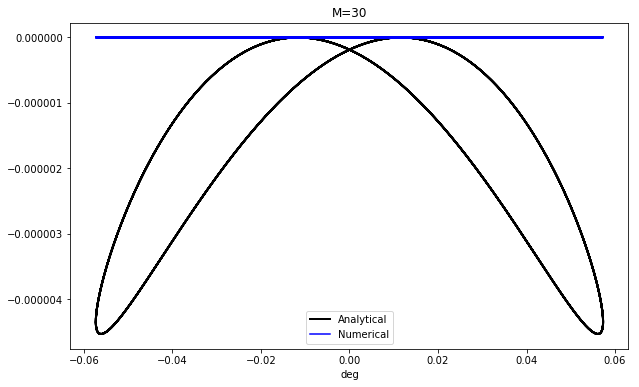

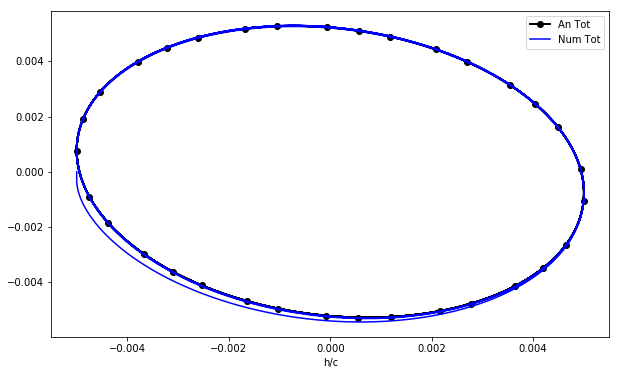

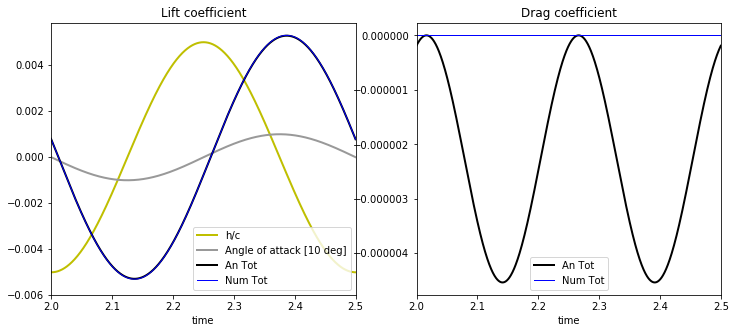

In [7]:
### Phase plots
fig = plt.figure('Induced drag in plunge motion -'
                                  ' Phase vs kinematics - exact derivative',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s'%M)
ax.legend()
plt.show()

fig = plt.figure('Lift in plunge motion - '
                                   'Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),
                                                label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(Slin.time,hc_num,'y',lw=2,label='h/c')
ax.plot(Slin.time,aeffv_num,'0.6',lw=2,label='Angle of attack [10 deg]')
ax.plot(Slin.time,CLtot_an,'k',lw=2,label='An Tot')
ax.plot(Slin.time,THCF[:,1],'b',lw=1,label='Num Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(Slin.time, Cdv,'k',lw=2,label='An Tot')
ax.plot(Slin.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()

plt.show() 

The lift prediction agreement is very good. As a result of the linearisation about $\alpha_{eff}=0$, however, the $\Delta F$ predicted is always perpendicular to the undisturbed flow speed (see valid_lin_sta). As a result, no drag is predicted. The drag obtained through Garrik solution, furthermore, arises from including second order terms, hence it is expected that a linear model would not be able to capture it.

### High reduced frequency

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


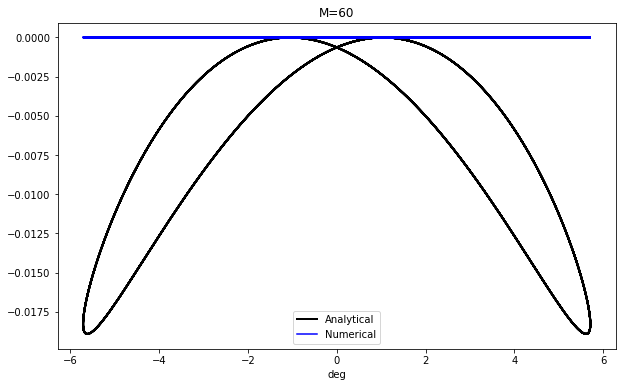

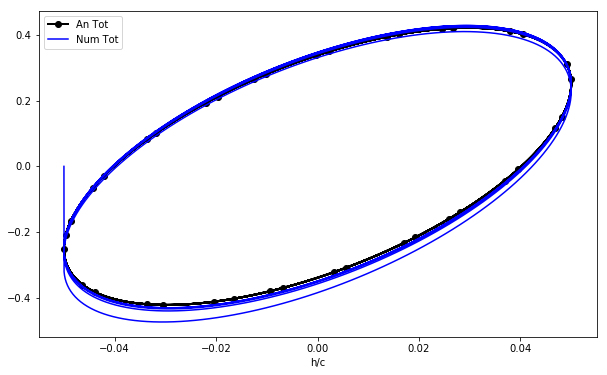

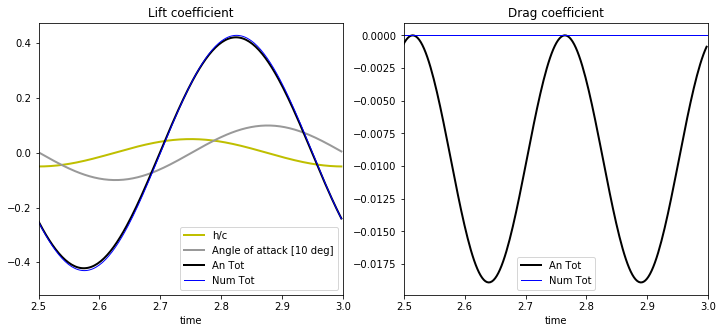

In [8]:
### random geometry
c=3.
b=0.5*c
ktarget=1.0
H=0.1*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
# Numerical solution
Ncycles=6.
WakeFact=30
T=2.*np.pi*Ncycles/w0
M=60

### reference static solution
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()
Ftot0=np.sum(S0.Faero,0)

# Linearised solution
Slin=lin_uvlm2d_dyn.solver(S0,T)
Slin=set_dyn.plunge(Slin,f0,H)
Slin.eps_Hall=0.003
with io.capture_output() as captured:
    Slin.solve_dyn_Gamma2d()

# total force
THFtot=0.0*Slin.THFaero
for tt in range(Slin.NT):
    THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0

### post-process
hc_num=(Slin.THZeta[:,0,1]-H)/S0.chord
aeffv_num=np.zeros((Slin.NT))
for tt in range(1,Slin.NT):
    aeffv_num[tt]=-np.arctan(
     (Slin.THZeta[tt,0,1]-Slin.THZeta[tt-1,0,1])/Slin.dt/S0.Uinf[0])  
THCF=THFtot/S0.qinf/S0.chord
THCFmass=Slin.THFaero_m/S0.qinf/S0.chord
THCFcirc=THCF-THCFmass        
       

### Analytical solution
hv_an=-H*np.cos(w0*Slin.time)
hc_an=hv_an/S0.chord
dhv=w0*H*np.sin(w0*Slin.time)
aeffv_an=np.arctan(-dhv/S0.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S0.chord,S0.rho,uinf,Slin.time)
# lift - Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(
                              w0,0,H,S0.chord,S0.rho,S0.Uinf[0],0.0)
ph_tot=np.angle(Ltot_an)
ph_circ=np.angle(Lcirc_an)
ph_mass=np.angle(Lmass_an)
CLtot_an=np.abs(Ltot_an)*np.cos(w0*Slin.time+ph_tot)/(S0.chord*S0.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*Slin.time+ph_circ)/(S0.chord*S0.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*Slin.time+ph_mass)/(S0.chord*S0.qinf)

### Phase plots
fig = plt.figure('Induced drag in plunge motion -'
                                  ' Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s'%M)
ax.legend()

fig = plt.figure('Lift in plunge motion - '
                                   'Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),
                                                label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(Slin.time,hc_num,'y',lw=2,label='h/c')
ax.plot(Slin.time,aeffv_num,'0.6',lw=2,label='Angle of attack [10 deg]')
ax.plot(Slin.time,CLtot_an,'k',lw=2,label='An Tot')
ax.plot(Slin.time,THCF[:,1],'b',lw=1,label='Num Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(Slin.time, Cdv,'k',lw=2,label='An Tot')
ax.plot(Slin.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()

plt.show()  

A sufficiently refined grid provides a very good convergence.

## Impulsive start

This test shows the solution to Wagner's problem.

In [9]:
# set-up
M=6
WakeFact=20
c=3.
b=0.5*c
uinf=20.0
aeff=1.0*np.pi/180.
T=8.0


### reference static solution - at zero - Hall's correction
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()
Ftot0=np.sum(S0.Faero,0)

Slin1=lin_uvlm2d_dyn.solver(S0,T=T)
ZetaRot=geo.rotate_aerofoil(S0.Zeta,aeff)
dZeta=ZetaRot-S0.Zeta
Slin1.Zeta=dZeta
for tt in range(Slin1.NT):
    Slin1.THZeta[tt,:,:]=dZeta
Slin1._imp_start=True
Slin1.eps_Hall=0.003
with io.capture_output() as captured:
    Slin1.solve_dyn_Gamma2d()



### reference static solution - at zero - no Hall's correction
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.eps_Hall=1.0
S0.solve_static_Gamma2d()

Slin2=lin_uvlm2d_dyn.solver(S0,T=T)
Slin2.Zeta=dZeta
for tt in range(Slin2.NT):
    Slin2.THZeta[tt,:,:]=dZeta
Slin2._imp_start=True
Slin2.eps_Hall=1.0
with io.capture_output() as captured:
    Slin2.solve_dyn_Gamma2d()

### Analytical solution
CLv_an=an.wagner_imp_start(aeff,uinf,c,Slin1.time)

##### Post-process numerical solution - Hall's correction
THFtot1=0.0*Slin1.THFaero
for tt in range(Slin1.NT):
    THFtot1[tt,:]=Slin1.THFaero[tt,:]+Ftot0
THCF1=THFtot1/S0.qinf/S0.chord
# Mass and circulatory contribution
THCFmass1=Slin1.THFaero_m/S0.qinf/S0.chord
THCFcirc1=THCF1-THCFmass1

##### Post-process numerical solution - no Hall's correction
THFtot2=0.0*Slin2.THFaero
for tt in range(Slin2.NT):
    THFtot2[tt,:]=Slin2.THFaero[tt,:]+Ftot0
THCF2=THFtot2/S0.qinf/S0.chord
# Mass and circulatory contribution
THCFmass2=Slin2.THFaero_m/S0.qinf/S0.chord
THCFcirc2=THCF2-THCFmass2

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


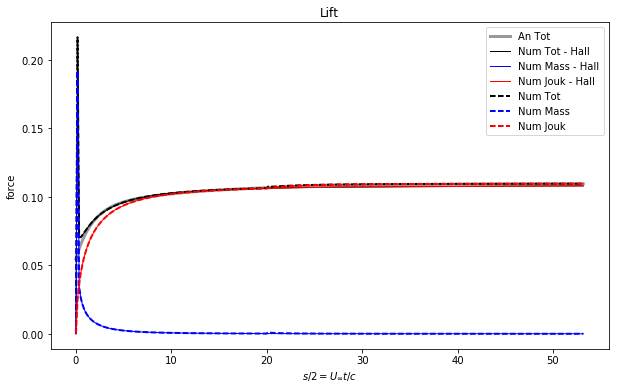

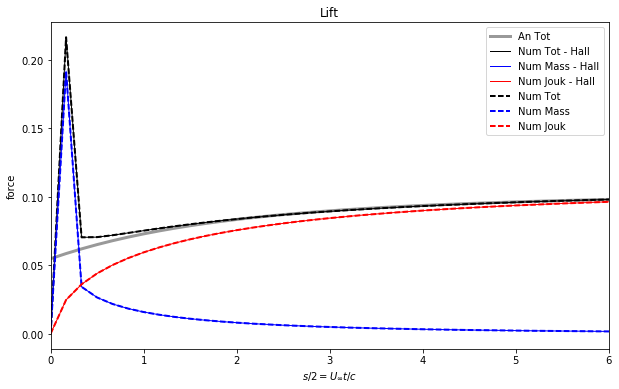

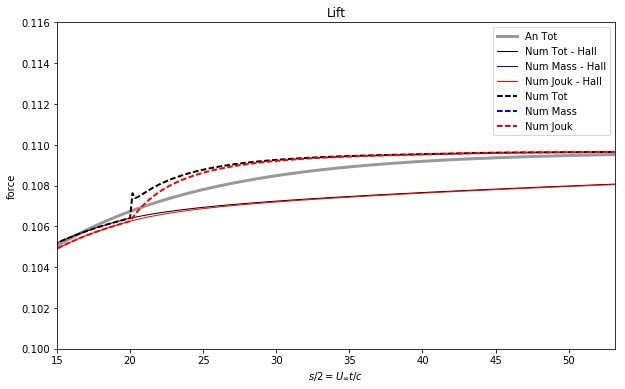

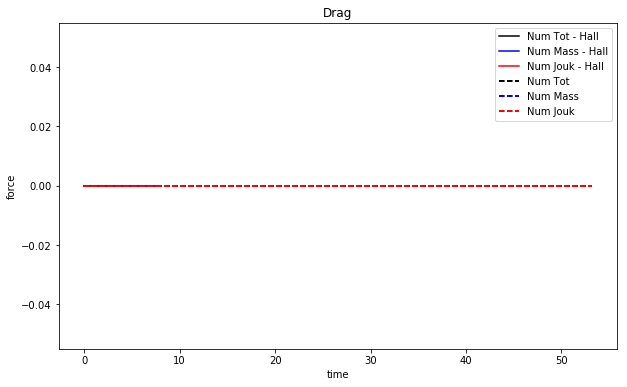

In [10]:
plt.close('all')
# non-dimensional time
sv=2.0*S0.Uabs*Slin1.time/S0.chord

fig = plt.figure('Lift coefficient',(10,6))
ax=fig.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF1[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass1[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc1[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()

fig2 = plt.figure('Lift coefficient - zoom',(10,6))
ax=fig2.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF1[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass1[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc1[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()
ax.set_xlim(0.,6.)

fig3 = plt.figure("Lift coefficient - Hall's correction effect",(10,6))
ax=fig3.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF1[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass1[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc1[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()
ax.set_xlim(15.,0.5*sv[-1])
ax.set_ylim( 0.10, 0.116 )


fig = plt.figure('Drag coefficient',(10,6))
ax=fig.add_subplot(111)
ax.plot(Slin1.time, THCF1[:,0],'k',label='Num Tot - Hall')
ax.plot(Slin1.time, THCFmass1[:,0],'b',label='Num Mass - Hall')
ax.plot(Slin1.time, THCFcirc1[:,0],'r',label='Num Jouk - Hall')
ax.plot(0.5*sv, THCF2[:,0],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,0],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,0],'r--',lw=2,label='Num Jouk')

ax.set_xlabel('time')
ax.set_ylabel('force')
ax.set_title('Drag')
ax.legend()

plt.show()

It can be observed that:
- Hall's correction has an impact of the force time history: while it avoids the discontinuity occurring when the first vortex shed at the trailing edge reaches the end of the wake, it worsen the convergence at the steady state. A fine tuning may be required.
- At $t=0$ the aerodynamic force jumps to a very high value: this is compatible with the backward first order approximation of the time derivative in the code - the analytical solution assumes an infinite increase of the aerodynamic force at $t=0$. Also note that the jump in aerodynamic force is linked to the unsteady (added mass) term.
- Drag is always zero.

## Sinusoidal gust
Finally, we consider the response to a sinusoidal gust (Sears' solution) at low/high values of the reduced frequency 
$$
k_g=\frac{\pi c}{\lambda_g}
$$
where $\lambda_g$ is the gust length. The aerofoil is linearised around a zero angle of attack.

### Low reduced frequency $k_g=0.2$

In [11]:
# random geometry
c=3.
b=0.5*c

# gust profile
w0=0.05
uinf=2.0
kg=0.2
L=np.pi*c/kg
print('Reduced frequency: %.2f' %kg)
print('Gust length %.2f chords'%(L/c))

# discretisation
WakeFact=25
Ncycles=12 # number of "cycles"
Mfact=15
if c>L: M=np.ceil(4*Mfact*c/L)
else: M=Mfact*4

# Reference state
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                           Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()
Ftot0=np.sum(S0.Faero,0)

# Linearised model
Slin=lin_uvlm2d_dyn.solver(S0,T=Ncycles*L/uinf)
Slin=set_gust.sin(Slin,w0,L,ImpStart=False)
Slin.eps_Hall=0.003
with io.capture_output() as captured:
    Slin.solve_dyn_Gamma2d()
THFtot=0.0*Slin.THFaero
for tt in range(Slin.NT):
    THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0    

THCF=THFtot/S0.qinf/S0.chord

# Analytical solution
CLv = an.sears_lift_sin_gust(w0,L,uinf,c,Slin.time)	

Reduced frequency: 0.20
Gust length 15.71 chords


../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


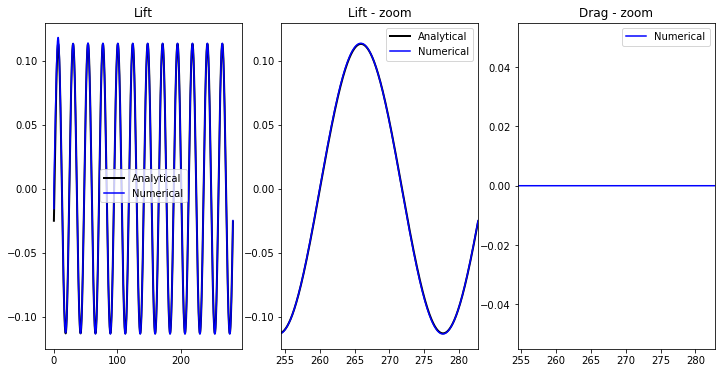

In [12]:
fig = plt.figure('Aerodynamic force coefficients',(12,6))
ax=fig.add_subplot(131)
ax.set_title(r'Lift')
ax.plot(Slin.time,CLv,'k',lw=2,label=r"Analytical")
ax.plot(Slin.time,THCF[:,1],'b',label=r'Numerical')
ax.legend()

ax2=fig.add_subplot(132)
ax2.set_title(r'Lift - zoom')
ax2.plot(Slin.time,CLv,'k',lw=2,label=r"Analytical")
ax2.plot(Slin.time,THCF[:,1],'b',label=r'Numerical')
ax2.set_xlim(0.9*Slin.T,Slin.T)
ax2.legend()

ax2=fig.add_subplot(133)
ax2.set_title(r'Drag - zoom')
ax2.plot(Slin.time,THCF[:,0],'b',label=r'Numerical')
ax2.set_xlim(0.9*Slin.T,Slin.T)
ax2.legend()

plt.show()

The agreement with the analytical theory is very good.

### High reduced frequency $k_g=1$

A more refined parametrisation, $M=80$, is here required.

In [13]:
# random geometry
c=3.
b=0.5*c

# gust profile
w0=0.05
uinf=2.0
kg=1.0
L=np.pi*c/kg
print('Reduced frequency: %.2f' %kg)
print('Gust length %.2f chords'%(L/c))

# discretisation
WakeFact=20
Ncycles=32 # number of "cycles"
Mfact=20
if c>L: M=np.ceil(4*Mfact*c/L)
else: M=Mfact*4
print('aerofoil panels M=%d' %M)
print('Panels per wavelength %d'%int(M*L/c))

# Reference state
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                           Uinf=np.array([uinf,0.]),alpha=0.0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()
Ftot0=np.sum(S0.Faero,0)

# Linearised model
Slin=lin_uvlm2d_dyn.solver(S0,T=Ncycles*L/uinf)
Slin=set_gust.sin(Slin,w0,L,ImpStart=False)
Slin.eps_Hall=0.003
with io.capture_output() as captured:
    Slin.solve_dyn_Gamma2d()
THFtot=0.0*Slin.THFaero
for tt in range(Slin.NT):
    THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0    

THCF=THFtot/S0.qinf/S0.chord

# Analytical solution
CLv = an.sears_lift_sin_gust(w0,L,uinf,c,Slin.time)	

Reduced frequency: 1.00
Gust length 3.14 chords
aerofoil panels M=80
Panels per wavelength 251


../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Error CL max: 0.022
Error Time maximum: 0.000


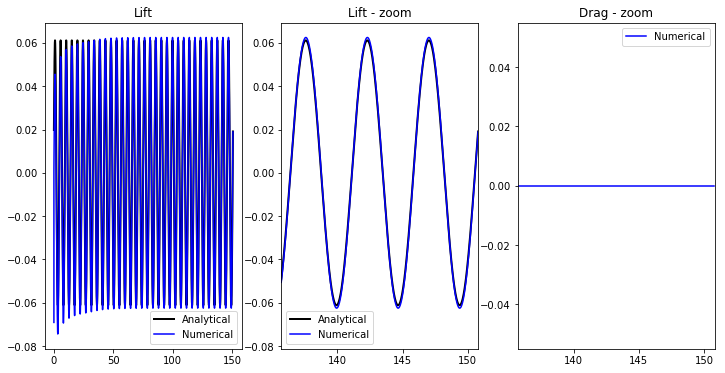

In [14]:
# post-process
ttvec=Slin.time>float(Ncycles-1)/Ncycles*Slin.T
# numerical solution
ttmax=np.argmax(THCF[ttvec,1])
Tmax=Slin.time[ttvec][ttmax]
CLmax=THCF[ttvec,1][ttmax]
# an. sol
ttmax=np.argmax(CLv[ttvec])
Tmax_an=Slin.time[ttvec][ttmax]
CLmax_an=CLv[ttvec][ttmax] 

ErCL= np.abs(CLmax/CLmax_an-1.0) 
Period=L/uinf
ErTmax=np.abs((Tmax-Tmax_an)/Period)
print('Error CL max: %.3f' %ErCL)
print('Error Time maximum: %.3f' %ErTmax)


fig = plt.figure('Aerodynamic force coefficients',(12,6))
ax=fig.add_subplot(131)
ax.set_title(r'Lift')
ax.plot(Slin.time,CLv,'k',lw=2,label=r"Analytical")
ax.plot(Slin.time,THCF[:,1],'b',label=r'Numerical')
ax.legend()

ax2=fig.add_subplot(132)
ax2.set_title(r'Lift - zoom')
ax2.plot(Slin.time,CLv,'k',lw=2,label=r"Analytical")
ax2.plot(Slin.time,THCF[:,1],'b',label=r'Numerical')
ax2.set_xlim(0.9*Slin.T,Slin.T)
ax2.legend()

ax2=fig.add_subplot(133)
ax2.set_title(r'Drag - zoom')
ax2.plot(Slin.time,THCF[:,0],'b',label=r'Numerical')
ax2.set_xlim(0.9*Slin.T,Slin.T)
ax2.legend()

plt.show()

Even in this case the agreement is satisfactory, with error in maximum amplitude of the lift coefficient below 3% anbd phase error of the order of the time-step.